## Import all Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')
import nltk.corpus
import os
import sys
import json
from collections import Counter
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
from ipywidgets import FloatProgress
from tqdm import tqdm
import pandas as pd

## Load the Dataset and Perform VADER Sentiment Analysis
The sentiment analysis is performed on review Text 

In [2]:
filename="Magazine_Subscriptions"
filepath = ('Datasets/'+filename+'.json')
df_raw = pd.read_json(filepath,lines=True)

# nltk.download('vader_lexicon')
sentiment = SentimentIntensityAnalyzer()
sid_obj = SentimentIntensityAnalyzer()
def get_compound_score(text):
    return sid_obj.polarity_scores(str(text))['compound']


df_raw['sentiment']=df_raw['reviewText'].swifter.apply(get_compound_score)

count=0
avg_rating=0
comp_rating=0
for index, row in df_raw.iterrows():
    ss = sentiment.polarity_scores(str(row['reviewText']))
    for k in sorted(ss):
        compound_score =ss['compound']
    
    avg_rating+=(compound_score+1)/2.0*5.0
    comp_rating+=(row.overall+compound_score/5.0)*(5/6)
    count+=1


if count > 0:
    avg_rating /= count
    comp_rating /= count

#Backup all the modifications in csv file
df_raw.to_csv('output/'+filename+'.csv', index=False)
df_raw=pd.read_csv('output/'+filename+'.csv')

df_raw['reviewTime'] = pd.to_datetime(df_raw['unixReviewTime'], unit='s')
df_raw.head()

Pandas Apply:   0%|          | 0/89689 [00:00<?, ?it/s]

C:\Users\SUBHASHIS\AppData\Local\Temp\ipykernel_14532\3539515959.py:33: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw=pd.read_csv('output/'+filename+'.csv')


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,sentiment
0,5,9,False,2001-11-08,AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN,0.9630
1,5,9,False,2001-10-31,AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN,0.5106
2,3,14,False,2007-03-24,A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN,0.9931
3,5,13,False,2006-11-10,A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN,0.8932
4,5,NaN,True,2014-07-14,A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN,0.6249


## Group the data in 7 days

In [3]:

df_grouped = df_raw.groupby(pd.Grouper(key='reviewTime', freq='7D')).agg(
    review_count=('reviewerID', 'count'),
    average_sentiment=('sentiment', 'mean'),
    average_rating=('overall', 'mean'),
    helpfulness=('vote','count')
).reset_index()

In [4]:
df_grouped=df_grouped.fillna(0)
df_grouped.set_index('reviewTime', inplace=True)
df_grouped.head()

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2001-10-26,134,0.815234,4.373134,103
2001-11-02,27,0.794089,4.555556,24
2001-11-09,14,0.870700,4.428571,14
2001-11-16,17,0.846706,4.411765,16
2001-11-23,26,0.756819,4.153846,24


In [5]:
# See average sentiment
print(df_grouped['average_sentiment'].min(),df_grouped['average_sentiment'].max())
min_sentiment=df_grouped['average_sentiment'].min()
max_sentiment=df_grouped['average_sentiment'].max()


df_grouped['average_sentiment']=1+(df_grouped['average_sentiment']-min_sentiment)*(5-1)/(max_sentiment-min_sentiment)

max_value = df_grouped['helpfulness'].max()
min_value = df_grouped['helpfulness'].min()

df_grouped['helpfulness']=1+ (df_grouped['helpfulness']-min_value)*(4)/(max_value-min_value)
df_grouped['mixture']=df_grouped['helpfulness']*df_grouped['average_sentiment']*df_grouped['average_rating']
df_grouped['mixture']=1+ (df_grouped['mixture']-min_value)*(4)/(max_value-min_value)


max_value = df_grouped['review_count'].max()
min_value = df_grouped['review_count'].min()

print(min_value,max_value)
df_grouped['review_count']=1+ (df_grouped['review_count']-min_value)*(4)/(max_value-min_value)

-0.13075000000000003 0.97385
2 528


In [6]:
df_grouped.head()

,review_count,average_sentiment,average_rating,helpfulness,mixture
reviewTime,,,,,
2001-10-26,2.003802,4.425618,4.373134,5.000000,4.758023
2001-11-02,1.190114,4.349045,4.555556,1.932039,2.486531
2001-11-09,1.091255,4.626471,4.428571,1.543689,2.228277
2001-11-16,1.114068,4.539583,4.411765,1.621359,2.261044
2001-11-23,1.182510,4.214084,4.153846,1.932039,2.313385


## Use RandomForestRegressor to determine the most important features

             Feature  Importance
2        helpfulness    0.546762
1     average_rating    0.233489
0  average_sentiment    0.159834
3            mixture    0.059915


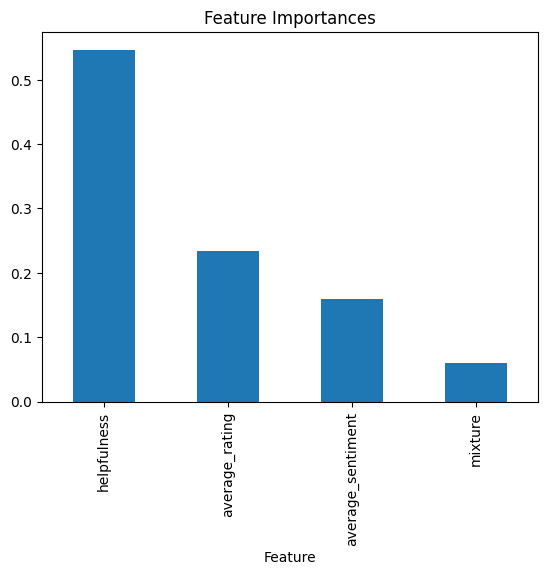

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming df_grouped is your DataFrame and 'review_count' is your target
X = df_grouped[['average_sentiment', 'average_rating', 'helpfulness', 'mixture']]
y = df_grouped['review_count']

# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

#Plot the feature importances
importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, title="Feature Importances")
plt.show()


In [8]:
feature_importance = dict(zip(importance_df['Feature'], importance_df['Importance']))

# Normalize the feature importance to sum to 1
total_importance = sum(feature_importance.values())

In [9]:
normalized_importance = {key: value / total_importance for key, value in feature_importance.items()}

# Scaling the relevant columns based on the normalized feature importance
df_scaled = df_grouped.copy()
df_scaled['helpfulness'] *= normalized_importance['helpfulness']
df_scaled['average_rating'] *= normalized_importance['average_rating']
df_scaled['average_sentiment'] *= normalized_importance['average_sentiment']

In [10]:
#  split train/valid/test
n = len(df_grouped)
train_end = int(n * 0.7)
val_end = n - int(n * 0.1)
test_end = n

seq_len=16
pred_len=60
batch_size=60

df_grouped_bak=df_grouped

df_grouped_bak['review_count'] = np.log(df_grouped_bak['review_count']+1)

log_min = df_grouped_bak['review_count'].min()
log_max = df_grouped_bak['review_count'].max()


df_grouped_bak=df_grouped_bak/10


In [11]:
train_df = df_grouped_bak[:train_end]
val_df = df_grouped_bak[train_end - seq_len: val_end]
test_df = df_grouped_bak[val_end - seq_len: test_end]

In [12]:
def _split_window(data,target_slice=slice(0,None)):
    inputs = data[:, : seq_len, :]
    labels = data[:, seq_len :, target_slice]
    inputs.set_shape([None, seq_len, None])
    labels.set_shape([None, pred_len, None])
    return inputs, labels

def _make_dataset(data, shuffle=True, targets=None):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=(seq_len + pred_len),
        sequence_stride=5,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    ds = ds.map(_split_window)
    return ds

def get_train(self, shuffle=True):
    return self._make_dataset(self.train_df, shuffle=shuffle)


In [13]:
import tensorflow as tf
train_data  =   _make_dataset(train_df, shuffle=False)
val_data    =   _make_dataset(val_df, shuffle=False)
test_data   =   _make_dataset(test_df, shuffle=False)

In [14]:
from tensorflow.keras import layers

def res_block(inputs, ff_dim):

  norm = layers.LayerNormalization

  # Time mixing
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation='relu')(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  res = x + inputs

  # Feature mixing
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  return (x + res ) #* (avg_rating/5.0) * (comp_rating/5.0)

def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  # Temporal projection
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)


n_feature = train_df.shape[-1]
model = build_model(
    input_shape=(seq_len, n_feature),
    pred_len=pred_len,
    n_block=16,
    ff_dim=64,
    target_slice=slice(0,None)
)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
tf.keras.utils.set_random_seed(7)

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=24,
    decay_rate=0.97,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer, loss='mse', metrics=['mse'])
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',           
    monitor='val_mse',        
    save_best_only=True,       # Save only the best model (lowest val_loss)
    mode='min',                
    verbose=1,
)


In [16]:
history = model.fit(
    train_data,
    epochs= 1000,
    validation_data=test_data,
    callbacks=[checkpoint_callback]
)

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 141.4359 - mse: 141.4359
Epoch 1: val_mse improved from inf to 0.89353, saving model to best_model.h5
2/2 [==============================] - 23s 4s/step - loss: 141.4359 - mse: 141.4359 - val_loss: 0.8935 - val_mse: 0.8935
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 29.8617 - mse: 29.8617
Epoch 2: val_mse did not improve from 0.89353
2/2 [==============================] - 0s 224ms/step - loss: 29.8617 - mse: 29.8617 - val_loss: 47.1447 - val_mse: 47.1447
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 51.8774 - mse: 51.8774
Epoch 3: val_mse did not improve from 0.89353
2/2 [==============================] - 0s 221ms/step - loss: 51.8774 - mse: 51.8774 - val_loss: 4.2182 - val_mse: 4.2182
Epoch 4/1000
2/2 [==============================] - ETA: 0s - loss: 8.8428 - mse: 8.8428
Epoch 4: val_mse did not improve from 0.89353
2/2 [==============================] - 0s 226ms/step - l

In [17]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

scaled_preds.shape

cols = ['review_count','average_sentiment','average_rating','helpfulness','mixture']
scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols



1/1 [==============================] - 3s 3s/step


average_sentiment
average_rating
helpfulness
mixture


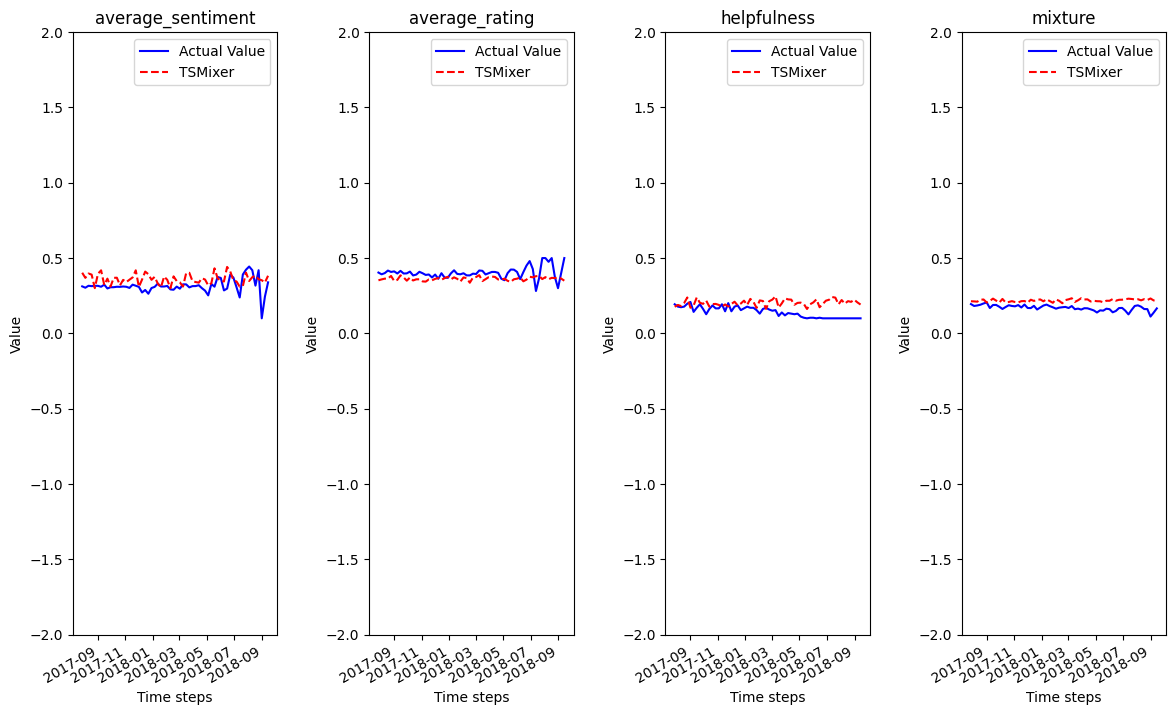

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,8))

for i, ax in enumerate(axes.flatten()[0:4]):
    col = cols[i+1]
    print(col)
    ax.plot(df_grouped.index[-pred_len:], df_grouped_bak[col][-pred_len:], label = 'Actual Value', color='blue')
    ax.plot(df_grouped.index[-pred_len:], scaled_preds_df[col], label='TSMixer', ls='--', color='red')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_ylim(-2, 2) 
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

plt.savefig('RESULT_VADER_SENTIMENT_'+filename+'.jpg')

In [19]:
for column in cols[1:5]:
    mse = ((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) ** 2).mean()
    print('MSE('+column+')='+str(round(mse*100,5))+'%')

MSE(average_sentiment)=0.52654%
MSE(average_rating)=0.33948%
MSE(helpfulness)=0.56689%
MSE(mixture)=0.28486%


In [20]:
actual_values = df_grouped_bak[column][-pred_len:].values
for column in cols[1:5]:
    msle = ((np.log1p(df_grouped_bak[column][-pred_len:].values) - np.log1p(scaled_preds_df[column].values)) ** 2).mean()
    print('MSLE('+column+')='+str(round(msle*100,5))+'%')

MSLE(average_sentiment)=0.30355%
MSLE(average_rating)=0.17316%
MSLE(helpfulness)=0.41865%
MSLE(mixture)=0.20166%


In [21]:
for column in cols[1:5]:
    mape= (abs((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) / df_grouped_bak[column][-pred_len:].values)).mean() * 100
    print('MAPE('+column+')='+str(round(mape,5))+'%')
    

MAPE(average_sentiment)=21.75055%
MAPE(average_rating)=11.45648%
MAPE(helpfulness)=54.5892%
MAPE(mixture)=30.57934%
